In [247]:
import pandas as pd
import numpy as np
import tensorflow as tf
#  import matplotlib.pyplot as plt
import pylab
import os
import pydicom
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,\
UpSampling2D, LeakyReLU, Conv2D
# , AvgPool2D, Lambda, LocallyConnected2D, Conv2D, multiply, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\
    # , LearningRateScheduler
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import layers
import keras_preprocessing.image as KPImage

# params we will probably want to do some hyperparameter optimization later

# ['InceptionV3', 'Xception', 'DenseNet169', 'VGG16']
BASE_MODEL = 'DenseNet121'
IMG_SIZE = (256, 256)  # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 32  # [1, 8, 16, 24]
DENSE_COUNT = 128  # [32, 64, 128, 256]
DROPOUT = 0.25  # [0, 0.25, 0.5]
LEARN_RATE = 1e-4  # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000  # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False  # [True, False]

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

In [29]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')

# Detailed contains whether patient has lung opacity, image is not normal or
# they are healthy
det_class_df = pd.read_csv('../input/stage_1_detailed_class_info.csv')
det_class_df = det_class_df.groupby('patientId').head(1).reset_index()
# Join the two tables
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='outer', on='patientId')
comb_bbox_df.head(3)

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'
path = '../input/stage_1_train_images/%s.dcm' % comb_bbox_df['patientId'][0]
dicom_header = pydicom.read_file(path, stop_before_pixels=True)

bbox_df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [39]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')
bbox_df[['x', 'y', 'width', 'height']] = bbox_df[['x', 'y', 'width', 'height']].fillna(0.0).astype('int')

# Create new dataframe with a column bbox which contains the info about the bounding box
comb_bbox_df = bbox_df
comb_bbox_df['bbox'] = bbox_df[['x', 'y', 'width', 'height']].values.tolist()
grouped_bbox_df = comb_bbox_df.groupby('patientId')['bbox'].apply(list)
grouped_bbox_df.head(10)

patientId
0004cfab-14fd-4e49-80ba-63a80b6bddd6                                  [[0, 0, 0, 0]]
00313ee0-9eaa-42f4-b0ab-c148ed3241cd                                  [[0, 0, 0, 0]]
00322d4d-1c29-4943-afc9-b6754be640eb                                  [[0, 0, 0, 0]]
003d8fa0-6bf1-40ed-b54c-ac657f8495c5                                  [[0, 0, 0, 0]]
00436515-870c-4b36-a041-de91049b9ab4    [[264, 152, 213, 379], [562, 152, 256, 453]]
00569f44-917d-4c86-a842-81832af98c30                                  [[0, 0, 0, 0]]
006cec2e-6ce2-4549-bffa-eadfcd1e9970                                  [[0, 0, 0, 0]]
00704310-78a8-4b38-8475-49f4573b2dbb    [[323, 577, 160, 104], [695, 575, 162, 137]]
008c19e8-a820-403a-930a-bc74a4053664                                  [[0, 0, 0, 0]]
009482dc-3db5-48d4-8580-5c89c4f01334                                  [[0, 0, 0, 0]]
Name: bbox, dtype: object

In [248]:
# we create two instances with the same arguments
data_gen_args = dict(samplewise_center=False, 
                     samplewise_std_normalization=False, 
                     horizontal_flip = True, 
                     vertical_flip = False, 
                     height_shift_range = 0.05, 
                     width_shift_range = 0.02, 
                     rotation_range = 3, 
                     shear_range = 0.01,
                     fill_mode = 'nearest',
                     validation_split = 0.1,
                     zoom_range = 0.05
                     #preprocessing_function=preprocess_input
                    )
#data_gen_args = {'validation_split': 0.1}
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 2018

image_dir = dicom_dir + 'sources'
target_dir = dicom_dir + 'masks'

train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
train_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
valid_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')
valid_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)

Found 23116 images belonging to 1 classes.
Found 23116 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.


In [102]:
# This takes a while and only needs to be ran once to generate all the necessary images

#for pid, boxes in grouped_bbox_df.items():
    #if os.path.isfile(os.path.join(dicom_dir, "src/" + str(pid) + ".png")):
    #    continue
    #if os.path.isfile(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png")):
    #    continue
    # load dicom file as numpy array

    img = pydicom.dcmread(os.path.join(dicom_dir, str(pid) + ".dcm")).pixel_array
    # create empty mask
    msk = np.zeros(img.shape, dtype=np.uint8)
    
    if boxes[0] != [0,0,0,0]:
        # loop through bounding boxes
        for box in boxes:
            # add 1's at the locations indicating pneumonia
            x, y, w, h = box
            msk[y:y + h, x:x + w] = 255
            
    
    msk2 = np.repeat(msk[:,:,np.newaxis], 3, axis=2)
    #msk2 = resize(msk2, (IMG_SIZE[0], IMG_SIZE[1], 3), mode='reflect')
    
    msk3 = Image.fromarray(msk2, 'RGB')
    msk3.thumbnail(IMG_SIZE)
    #if boxes[0] != [0,0,0,0]:
        # msk3.show()
    msk3.save(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png"))
    
    # resize image and scale up to 8bit colorspace, dont need to multiply by 255
#    img2 = np.repeat(img[:,:,np.newaxis], 3, axis=2)
#    img3 = Image.fromarray(img2, 'RGB')
#    img3.thumbnail(IMG_SIZE)
#    img3.save(os.path.join(dicom_dir, "sources/src/" + str(pid) + ".png"))

(32, 256, 256, 3) (32, 256, 256, 3)
[200.52327 200.52327 200.52327 ... 216.11707 216.11707 216.11707]
[200.52327 200.52327 200.52327 ... 216.11707 216.11707 216.11707]


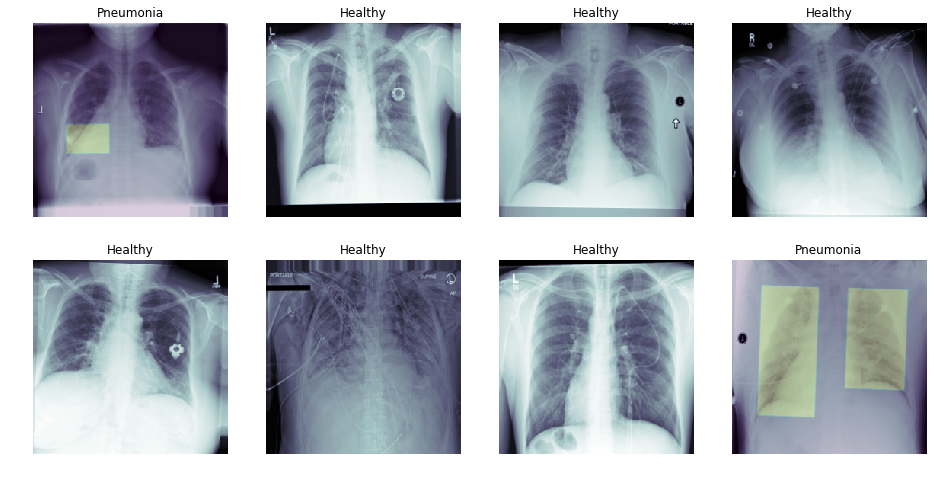

In [225]:
train_src, train_tar = next(train_generator)

print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (t_src, t_tar, ax) in zip(train_src, train_tar, m_axs.flatten()):
    ax.imshow(t_src[:,:,0], cmap = 'bone')
    if np.all(t_tar<1):
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        ax.imshow(t_tar[:,:,0], alpha=0.2)
        print(train_tar[train_tar>200])
    ax.set_title('%s' % title)
    ax.axis('off')

In [210]:
print(train_src.shape[1:])
base_pretrained_model = PTModel(input_shape = train_src.shape[1:], 
                                include_top = False)
base_pretrained_model.trainable = False
#print(base_pretrained_model.get_input_shape_at(0)[1:])

(256, 256, 3)
(256, 256, 3)


In [211]:
#pt_features = Input(train_src.shape[1:], name = 'feature_input')
#pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

#bn_features = BatchNormalization()(pt_features)
#gap = GlobalAveragePooling2D()(bn_features)
#gap_dr = Dropout(DROPOUT)(gap)
#dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
#dr_steps = BatchNormalization()(dr_steps)
#dr_steps = layers.LeakyReLU(0.1)(dr_steps)
#out_layer = Dense(train_tar.shape[1], activation = 'softmax')(dr_steps)

#attn_model = Model(inputs = [pt_features], 
#                   outputs = [out_layer], name = 'trained_model')


pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
outputs = BatchNormalization(momentum=0.9)(pt_features)
outputs = LeakyReLU(0)(outputs)
outputs = Conv2D(1, 1, activation='sigmoid')(outputs)
outputs = UpSampling2D(32)(outputs)
model = Model(inputs=pt_features,
              outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 1)           1025      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 256, 256, 1)       0         
Total params: 5,121
Trainable params: 3,073
Non-trainable params: 2,048
_________________________________________________________________


In [212]:
pneu_model = Sequential(name = 'combined_model')
pneu_model.add(base_pretrained_model)
pneu_model.add(model)
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
model_3 (Model)              (None, 256, 256, 1)       5121      
Total params: 7,042,625
Trainable params: 3,073
Non-trainable params: 7,039,552
_________________________________________________________________


In [235]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    split0 = tf.divide(split0, 255)
    return 0.5 * binary_crossentropy(split0, y_pred) + 0.5 * iou_loss(split0, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    #print(tf.shape(split0))
    #print(tf.shape(y_pred))
    split0 = tf.divide(split0, 255)
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(split0 * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(split0, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
pneu_model.compile(optimizer=Adam(lr = LEARN_RATE),
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [214]:
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [239]:
history = pneu_model.fit_generator(train_generator, 
                                   steps_per_epoch=train_image_generator.n//BATCH_SIZE,
                                   validation_data=valid_generator,
                                   validation_steps=valid_image_generator.n//BATCH_SIZE,
                                   epochs=20, 
                                   callbacks=callbacks_list,
                                   workers=1
                                   )

Epoch 1/20
963/963 [==============================] - 525s 545ms/step - loss: 0.4846 - acc: 0.9645 - mean_iou: 0.6703 - val_loss: 0.8344 - val_acc: 0.9525 - val_mean_iou: 0.6481

Epoch 00001: val_loss did not improve from 0.81787
Epoch 2/20
963/963 [==============================] - 522s 542ms/step - loss: 0.4724 - acc: 0.9622 - mean_iou: 0.6565 - val_loss: 0.8243 - val_acc: 0.9538 - val_mean_iou: 0.6574

Epoch 00002: val_loss did not improve from 0.81787
Epoch 3/20
963/963 [==============================] - 522s 542ms/step - loss: 0.4678 - acc: 0.9612 - mean_iou: 0.6535 - val_loss: 0.8487 - val_acc: 0.9501 - val_mean_iou: 0.6387

Epoch 00003: val_loss did not improve from 0.81787
Epoch 4/20
963/963 [==============================] - 521s 541ms/step - loss: 0.4644 - acc: 0.9607 - mean_iou: 0.6509 - val_loss: 0.8204 - val_acc: 0.9540 - val_mean_iou: 0.6574

Epoch 00004: val_loss did not improve from 0.81787
Epoch 5/20
963/963 [==============================] - 521s 541ms/step - loss: 0.

In [240]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

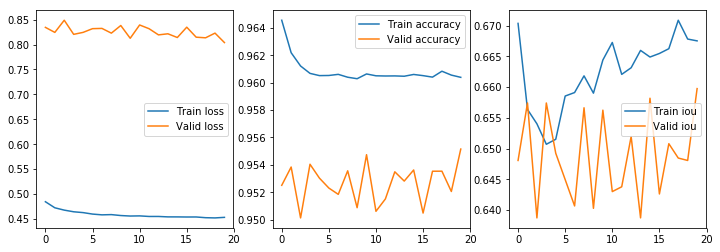

In [241]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [246]:
valid_set = next(valid_image_generator)
valid_tar = next(valid_mask_generator)
preds = pneu_model.predict(valid_set,
                            batch_size = BATCH_SIZE, 
                            verbose = True)

24/24 [==============================] - 0s 6ms/step


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[0.12371466]
 [0.12371466]
 [0.12371466]
 ...
 [0.12371466]
 [0.12371466]
 [0.12371466]]
[]
[]
[]
[]
[]


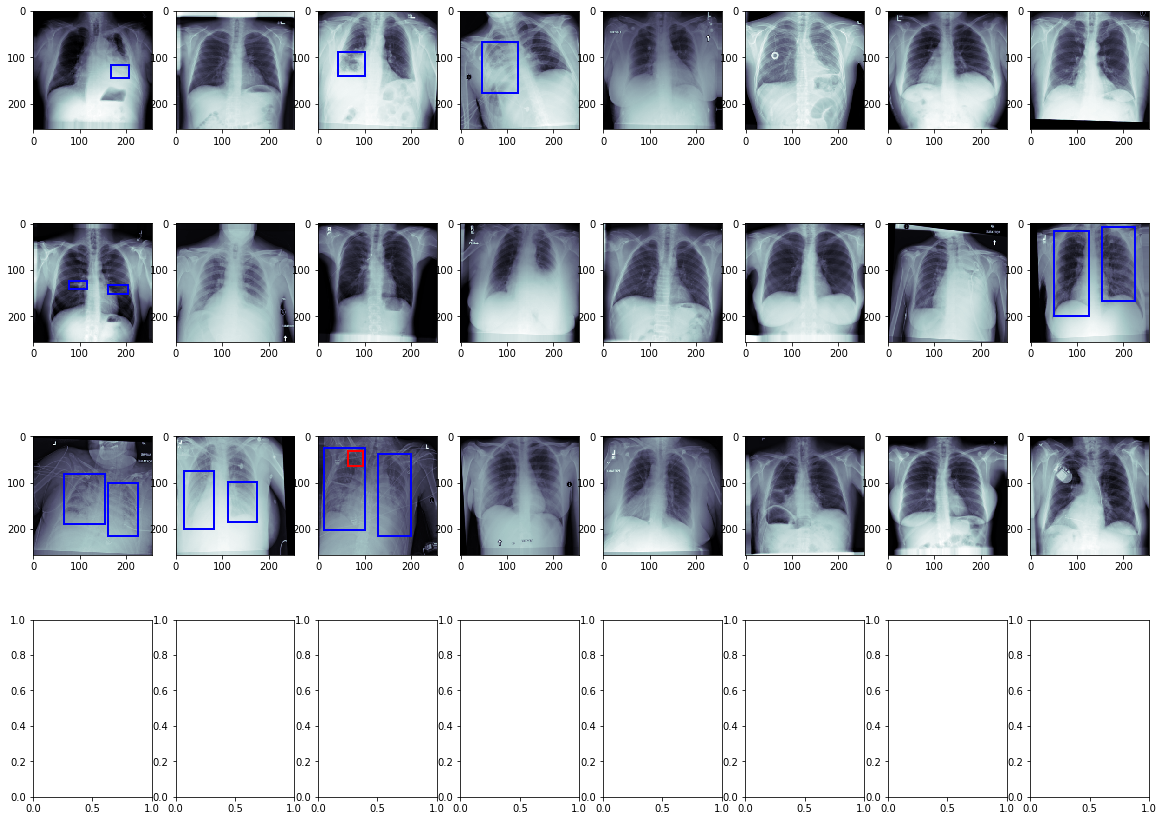

In [245]:
f, axarr = plt.subplots(4, 8, figsize=(20,15))
axarr = axarr.ravel()
axidx = 0
# loop through batch
for img, msk, pred in zip(valid_set, valid_tar, preds):
    # plot image
    msk = msk/255
    axarr[axidx].imshow(img[:, :, 0], cmap='bone')
    # threshold true mask
    comp = msk[:, :, 0] > 0.5
    # apply connected components
    comp = measure.label(comp)
    # apply bounding boxes
    predictionString = ''
    for region in measure.regionprops(comp):
        # retrieve x, y, height and width
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
    # threshold predicted mask
    comp = pred[:, :, 0] > 0.1
    print(pred[comp])
    # apply connected components
    comp = measure.label(comp)
    # apply bounding boxes
    predictionString = ''
    for region in measure.regionprops(comp):
        # retrieve x, y, height and width
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
    axidx += 1
plt.show()
# only plot one batch